In [49]:
import re
from collections import defaultdict
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import logomaker as lm
from matplotlib import pyplot as plt
from Bio import SeqIO

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [50]:
def z_score(preds, rel_indices=None):
    if rel_indices is not None:
        rel_preds = preds[rel_indices]
        mean, std = np.mean(rel_preds), np.std(rel_preds)
    else:
        mean, std = np.mean(preds), np.std(preds)
    return (preds - mean) / std

In [51]:
df_motifs = pd.read_csv("/home/alex/fimo_YEAST_merge_W303_Mmmyco/fimo.tsv", sep="\t", comment='#')
df_motifs

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,Hap1p&consensus=TCGCGTTCATATATATCGGATATACTCTTG...,Hap1p,chrXII,671542,671581,+,74.7273,1.830000e-24,4.440000e-17,TCGCGTTCATATATATCGGATATACTCTTGAGGCACAATT
1,Crz1p&consensus=CACCAGTCGGTGGCTGTGCGCTTG,Crz1p,chrVII,542935,542958,+,46.7879,1.440000e-15,3.850000e-08,CACCAGTCGGTGGCTGTGCGCTTG
2,Abf1p&consensus=AGCCGTAAATAGTTATCTTCCAAG,Abf1p,chrV,477850,477873,+,44.8364,5.710000e-15,1.410000e-07,AGCCGTAAATAGTTATCTTCCAAG
3,Fzf1p&consensus=CGTATCGTATAAGGCAACAATAG,Fzf1p,chrXVI,373482,373504,+,43.0727,2.080000e-14,5.310000e-07,CGTATCGTATAAGGCAACAATAG
4,YOX1.1,NaN,chrIV,844758,844777,+,32.8265,1.490000e-12,3.540000e-05,AATTACGTTTCCTAAAAGGG
...,...,...,...,...,...,...,...,...,...,...
2039301,Rph1p&consensus=aaxxxDaWTtAGGGGKgxa,Rph1p,chrXIII,316485,316503,+,10.0303,1.000000e-04,1.000000e+00,AAAAAAATTTACGGGGAAG
2039302,Rph1p&consensus=aaxxxDaWTtAGGGGKgxa,Rph1p,chrII,323112,323130,+,10.0303,1.000000e-04,1.000000e+00,AAATAAAATCAGGGAGAAA
2039303,Rph1p&consensus=aaxxxDaWTtAGGGGKgxa,Rph1p,chrX,734078,734096,-,10.0303,1.000000e-04,1.000000e+00,CAATAAAATTAGTGGGAAA
2039304,Rph1p&consensus=aaxxxDaWTtAGGGGKgxa,Rph1p,chrXII,995289,995307,+,10.0303,1.000000e-04,1.000000e+00,AAAAAGCTTTAGCGGTATA


In [52]:
df_8A = pd.read_csv("/home/alex/fimo_8A_W303_Mmmyco/fimo.tsv", sep="\t", comment='#')
df_8A

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,AAAAAAAA,TTTTTTTT,chrXVI,71,78,+,14.8911,0.000032,0.0383,AAAAAAAA
1,AAAAAAAA,TTTTTTTT,chrXVI,72,79,+,14.8911,0.000032,0.0383,AAAAAAAA
2,AAAAAAAA,TTTTTTTT,chrXVI,73,80,+,14.8911,0.000032,0.0383,AAAAAAAA
3,AAAAAAAA,TTTTTTTT,chrXVI,74,81,+,14.8911,0.000032,0.0383,AAAAAAAA
4,AAAAAAAA,TTTTTTTT,chrVIII,75,82,+,14.8911,0.000032,0.0383,AAAAAAAA
...,...,...,...,...,...,...,...,...,...,...
18823,AAAAAAAA,TTTTTTTT,chrIV,1541034,1541041,-,14.8911,0.000032,0.0383,AAAAAAAA
18824,AAAAAAAA,TTTTTTTT,chrIV,1541035,1541042,-,14.8911,0.000032,0.0383,AAAAAAAA
18825,AAAAAAAA,TTTTTTTT,chrIV,1541036,1541043,-,14.8911,0.000032,0.0383,AAAAAAAA
18826,AAAAAAAA,TTTTTTTT,chrIV,1541037,1541044,-,14.8911,0.000032,0.0383,AAAAAAAA


In [231]:
model_name = "model_myco_nuc_2"  # "model_myco_pol_17"  # "model_myco_coh_14"  #
suffix = "_merge19_extend10"
cpt = 1
dfs = []
while Path(f"/home/alex/xstreme_nomeme_background_W303_saliency_{model_name}_peaks_yeastchroms{suffix}/fimo_out_{cpt}/fimo.tsv").exists():
    file = f"/home/alex/xstreme_nomeme_background_W303_saliency_{model_name}_peaks_yeastchroms{suffix}/fimo_out_{cpt}/fimo.tsv"
    cpt += 1
    try:
        dfs.append(pd.read_csv(file, sep='\t', comment="#").drop_duplicates())
    except pd.errors.EmptyDataError:
        print(f"{file} was empty. Skipping...")
        continue
df_streme = pd.concat(dfs).reset_index()
df_streme

,index,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,0,1-KCCGGGTAAYRAW,STREME-1,chrVII,854267,854279,+,19.66220,1.300000e-08,0.0127,TCCGGGTAACAAA
1,1,1-KCCGGGTAAYRAW,STREME-1,chrIX,153625,153637,-,19.44590,2.110000e-08,0.0127,GCCGGGTAACAAA
2,2,1-KCCGGGTAAYRAW,STREME-1,chrXV,832596,832608,-,18.74320,8.940000e-08,0.0141,GCCGGGTAACAGA
3,3,1-KCCGGGTAAYRAW,STREME-1,chrV,101807,101819,+,18.71620,1.190000e-07,0.0141,TCCGGGTAATAAA
4,4,1-KCCGGGTAAYRAW,STREME-1,chrIX,144522,144534,+,18.71620,1.190000e-07,0.0141,TCCGGGTAACAAG
...,...,...,...,...,...,...,...,...,...,...,...
5626,471,8-AWTAGCCGCCSA,STREME-8,chrXIV,418130,418141,+,6.79310,9.690000e-05,0.2510,ATTACCCGCTCC
5627,472,8-AWTAGCCGCCSA,STREME-8,chrIV,571736,571747,+,6.79310,9.690000e-05,0.2510,ATTACCCGCTCG
5628,473,8-AWTAGCCGCCSA,STREME-8,chrXIII,557343,557354,-,6.78161,9.710000e-05,0.2510,AGTTGCCGCGAT
5629,474,8-AWTAGCCGCCSA,STREME-8,chrV,572072,572083,-,6.74713,9.820000e-05,0.2540,CTTTGCCGCGGC


In [232]:
df_streme_in_yeast = pd.read_csv(f"/home/alex/xstreme_nomeme_background_W303_saliency_{model_name}_peaks_yeastchroms{suffix}/fimo_streme_out/fimo.tsv", sep='\t', comment='#')
df_streme_in_yeast

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,4-GGAATCGAACCCSGR,STREME-4,chrXV,594344,594358,+,25.92130,1.060000e-09,0.00286,GGAATCGAACCCGGG
1,4-GGAATCGAACCCSGR,STREME-4,chrIV,1259108,1259122,+,25.92130,1.060000e-09,0.00286,GGAATCGAACCCGGG
2,6-GCGATGAGAWRAAAA,STREME-6,chrXIV,485946,485960,+,21.97560,1.160000e-09,0.01040,GCGATGAGATGAAAA
3,6-GCGATGAGAWRAAAA,STREME-6,chrXIV,510868,510882,-,21.97560,1.160000e-09,0.01040,GCGATGAGATGAAAA
4,6-GCGATGAGAWRAAAA,STREME-6,chrIV,834236,834250,-,21.97560,1.160000e-09,0.01040,GCGATGAGATGAAAA
...,...,...,...,...,...,...,...,...,...,...
48874,8-AWTAGCCGCCSA,STREME-8,chrXIII,446750,446761,+,7.54878,9.990000e-05,1.00000,CAAAGCCGCTAA
48875,8-AWTAGCCGCCSA,STREME-8,chrXIV,643860,643871,+,7.54878,9.990000e-05,1.00000,CAAAGCCGCTAA
48876,8-AWTAGCCGCCSA,STREME-8,chrXV,662792,662803,+,7.54878,9.990000e-05,1.00000,CAAAGCCGCTAA
48877,8-AWTAGCCGCCSA,STREME-8,chrIV,800904,800915,-,7.54878,9.990000e-05,1.00000,TTTAACCGCTGT


In [233]:
sites = list(SeqIO.parse(f"/home/alex/shared_folder/SCerevisiae/results/{model_name}/saliency_{model_name}_peaks_yeastchroms{suffix}.fa", format="fasta"))
print(len(sites))

12125


In [234]:
total_length = sum(len(seq) for seq in SeqIO.parse("/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa", format='fasta') if seq.id.startswith("chr"))
total_site_length = sum(len(seq) for seq in sites)
expected_freq = total_site_length / total_length
print(total_site_length, total_length, expected_freq, sep='\t')

754434	12189794	0.06189062752003849


In [235]:
sites_with_motif = defaultdict(int)
for seq in sites:
    seqid, chr_id, start, stop = re.split(' |:|-', seq.description)
    start, stop = int(start), int(stop)
    # print(chr_id, start, stop)
    subdf = df_streme.loc[(df_streme.sequence_name == chr_id) & (df_streme.start >= start) & (df_streme.stop <= stop), "motif_id"]
    if len(subdf) > 0:
        motifs = subdf.unique()
        for motif in motifs:
            sites_with_motif[motif] += 1
sites_with_motif = dict(sorted(sites_with_motif.items()))
sites_with_motif

{'1-KCCGGGTAAYRAW': 699,
 '2-AAAATAAAAAAAAA': 1756,
 '3-AACAATAR': 176,
 '4-GGAATCGAACCCSGR': 186,
 '5-ATTTTTCA': 512,
 '6-GCGATGAGAWRAAAA': 652,
 '7-GCACGTGACC': 217,
 '8-AWTAGCCGCCSA': 463}

In [236]:
df = df_streme_in_yeast  # df_8A  #
sites_with_motif = defaultdict(int)
explained_sites = 0
for seq in sites:
    seqid, chr_id, start, stop = re.split(' |:|-', seq.description)
    start, stop = int(start), int(stop)
    # print(chr_id, start, stop)
    subdf = df.loc[(df.sequence_name == chr_id) & (df.start >= start) & (df.stop <= stop), "motif_id"]
    if len(subdf) > 0:
        explained_sites += 1
        motifs = subdf.unique()
        for motif in motifs:
            sites_with_motif[motif] += 1
sites_with_motif = dict(sorted(sites_with_motif.items()))
sites_with_motif

{'1-KCCGGGTAAYRAW': 598,
 '2-AAAATAAAAAAAAA': 2472,
 '3-AACAATAR': 238,
 '4-GGAATCGAACCCSGR': 141,
 '5-ATTTTTCA': 522,
 '6-GCGATGAGAWRAAAA': 657,
 '7-GCACGTGACC': 162,
 '8-AWTAGCCGCCSA': 341}

In [237]:
explained_sites, sum(sites_with_motif.values())

(4163, 5131)

In [238]:
occurences = df.loc[df.sequence_name != 'Mmmyco'].groupby("motif_id").count().max(axis=1)
for k, v in sites_with_motif.items():
    freq = v / occurences.loc[k]
    signif = "***" if freq > .5 else "**" if freq > .3 else "*" if freq > .2 else ''
    print(k, v, occurences.loc[k], freq, signif, sep='\t')

1-KCCGGGTAAYRAW	598	1471	0.4065261726716519	**
2-AAAATAAAAAAAAA	2472	25342	0.09754557651329808	
3-AACAATAR	238	4209	0.05654549774293181	
4-GGAATCGAACCCSGR	141	1612	0.08746898263027296	
5-ATTTTTCA	522	2800	0.18642857142857142	
6-GCGATGAGAWRAAAA	657	3776	0.1739936440677966	
7-GCACGTGACC	162	1010	0.1603960396039604	
8-AWTAGCCGCCSA	341	1849	0.18442401297998917	


In [122]:
for motif_id in sorted(df_motifs['motif_id'].unique()):
    if 'ume6' in motif_id.lower():
        print(motif_id)

UME6.1
UME6.2
Ume6p&consensus=TAGCCGCCGA
Ume6p&consensus=tWRCCGCgg
Ume6p&consensus=tWxcCGCB
Ume6p&consensus=tagcCGCB
Ume6p&consensus=txxaDaTWGCCGCcgaxaa


In [123]:
sites_with_yeastmotif = defaultdict(int)
for motif_id in sorted(df_motifs['motif_id'].unique()):
    if 'ume6' not in motif_id.lower():
        continue
    df = df_motifs.loc[df_motifs.motif_id == motif_id, :]
    for seq in sites:
        seqid, chr_id, start, stop = re.split(' |:|-', seq.description)
        start, stop = int(start), int(stop)
        # print(chr_id, start, stop)
        subdf = df.loc[(df.sequence_name == chr_id) & (df.start >= start) & (df.stop <= stop), "motif_id"]
        if len(subdf) > 0:
            motifs = subdf.unique()
            for motif in motifs:
                sites_with_yeastmotif[motif] += 1
sites_with_yeastmotif = dict(sorted(sites_with_yeastmotif.items()))
sites_with_yeastmotif

{'UME6.1': 311,
 'UME6.2': 336,
 'Ume6p&consensus=TAGCCGCCGA': 139,
 'Ume6p&consensus=tWRCCGCgg': 185,
 'Ume6p&consensus=tWxcCGCB': 286,
 'Ume6p&consensus=tagcCGCB': 244,
 'Ume6p&consensus=txxaDaTWGCCGCcgaxaa': 275}

In [124]:
occurences = df_motifs.loc[df_motifs.sequence_name != 'Mmmyco'].groupby("motif_id").count().max(axis=1)
for k, v in sites_with_yeastmotif.items():
    freq = v / occurences.loc[k]
    signif = "***" if freq > .5 else "**" if freq > .3 else "*" if freq > .2 else ''
    print(k, v, occurences.loc[k], freq, signif, sep='\t')

UME6.1	311	1760	0.17670454545454545	
UME6.2	336	1922	0.17481789802289283	
Ume6p&consensus=TAGCCGCCGA	139	622	0.22347266881028938	*
Ume6p&consensus=tWRCCGCgg	185	1014	0.18244575936883628	
Ume6p&consensus=tWxcCGCB	286	1054	0.2713472485768501	*
Ume6p&consensus=tagcCGCB	244	1220	0.2	
Ume6p&consensus=txxaDaTWGCCGCcgaxaa	275	1920	0.14322916666666666	


In [ ]:
motif_names = ["Abf1p&consensus=RTCaYtxtxtACGR", "UME6", "REB1", "Azf1p&consensus=AAGAAAAA", "Cbf1p&consensus=CACGTGAcc"]


          A         C         G         T
0  0.000000  1.000000  0.000000  0.000000
1  1.000000  0.000000  0.000000  0.000000
2  0.000000  1.000000  0.000000  0.000000
3  0.000000  0.000000  1.000000  0.000000
4  0.000000  0.000000  0.000000  1.000000
5  0.000000  0.000000  1.000000  0.000000
6  1.000000  0.000000  0.000000  0.000000
7  0.166333  0.501002  0.166333  0.166333
8  0.166333  0.501002  0.166333  0.166333


/home/alex/miniconda3/envs/plots/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


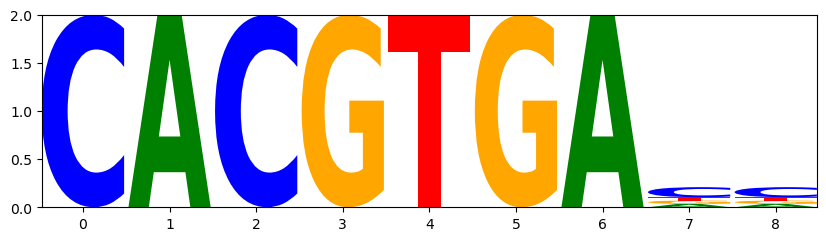

In [132]:
def get_motif(motif_name, meme_file):
    with open(meme_file) as f:
        line = f.readline()
        while line:
            if f"MOTIF {motif_name}" in line:
                while True:
                    line = f.readline()
                    if "letter-probability matrix" in line:
                        break
                motif_length = int(line.split("w= ")[1].split()[0])
                motif = []
                for i in range(motif_length):
                    line = f.readline().rstrip()
                    motif.append([float(num) for num in line.split()])
                motif = pd.DataFrame(motif, columns=list('ACGT'))
                return motif
            line = f.readline()
    return None


def plot_motif(motif, ax=None):
    pwm = motif * np.log2(motif)
    pwm.fillna(0, inplace=True)
    lm.Logo(motif.multiply(2 + pwm.sum(axis=1), axis=0), ax=ax)

meme_file_option = "YEASTRACT_20130918.meme"  # "macisaac_yeast.v1.meme"  # "SwissRegulon_s_cer.meme"  # "scpd_matrix.meme"  # "yeast_uniprobe_GR09.meme"  #
meme_file = f"/home/alex/motif_databases/YEAST/{meme_file_option}"
motif_name = "Cbf1p&consensus=CACGTGAcc"
motif = get_motif(motif_name, meme_file)
print(motif)
plot_motif(motif)

In [243]:
motif_match = [
    ("REB1", "SwissRegulon_s_cer"),
    ("ORC1", "SwissRegulon_s_cer"),
    ("Rox1p&consensus=YYYATTGTTCTC", "YEASTRACT_20130918"),
    ("SNF", "macisaac_yeast.v1"),
    ("Stb3p&consensus=gtHHaaAWTTTTTCAct", "YEASTRACT_20130918"),
    ("DOT6", "SwissRegulon_s_cer"),
    ("CBF1", "macisaac_yeast.v1"),
    ("UME6", "SwissRegulon_s_cer"),
    ("ABF1", "macisaac_yeast.v1")
]
# motif_match = [
#     None,
#     None,
#     ("MOT3", "YEASTRACT_20130918"),
#     ("REB1", "YEASTRACT_20130918"),
#     ("MOT3", "YEASTRACT_20130918"),
#     ("DOT6", "YEASTRACT_20130918"),
# ]
# motif_match = [
#     ("DAL80", "macisaac_yeast.v1"),
#     ("YAP6", "macisaac_yeast.v1"),
#     ("MATALPHA2", "SwissRegulon_s_cer"),
#     None,
#     ("YPR015C", "SwissRegulon_s_cer"),
#     ("ARG81", "YEASTRACT_20130918"),
# ]

In [182]:
import pickle
from typing import Union

def safe_filename(file: Union[Path, str]) -> Path:
    """Make sure file can be build without overriding an other.

    If file already exists, returns a new filename with a number in between
    parenthesis. If the parent of the file doesn't exist, it is created.

    Raises
    ------
    FileExistsError
        If one of the parents of the file to create is an existing file
    """
    file = Path(file)
    # Build parent directories if needed
    if not file.parent.is_dir():
        print("Building parent directories")
        file.parent.mkdir(parents=True)
    # Change filename if it already exists
    if file.exists():
        original_file = file
        file_dups = 0
        while file.exists():
            file_dups += 1
            file = Path(
                file.parent, original_file.stem + f"({file_dups})" + file.suffix
            )
            # python3.9: file.with_stem(original_file.stem + f'({file_dups})')
        print(f"{original_file} exists, changing filename to {file}")
    return file

def save_fig_and_values(fig, filename, format='png'):
    if isinstance(format, str):
        imgfile = safe_filename(str(filename) + f'.{format}')
        fig.savefig(imgfile, bbox_inches='tight')
    else:
        for form in format:
            imgfile = safe_filename(str(filename) + f'.{form}')
            fig.savefig(imgfile, bbox_inches='tight')
    picklefile = safe_filename(str(filename) + '.pickle')
    with open(picklefile, 'wb') as f:
        pickle.dump(fig, f)

/home/alex/motifs_xstreme_model_myco_nuc_2_saliency_peaks_min2_merge19_extend10.svg exists, changing filename to /home/alex/motifs_xstreme_model_myco_nuc_2_saliency_peaks_min2_merge19_extend10(2).svg
/home/alex/motifs_xstreme_model_myco_nuc_2_saliency_peaks_min2_merge19_extend10.pickle exists, changing filename to /home/alex/motifs_xstreme_model_myco_nuc_2_saliency_peaks_min2_merge19_extend10(2).pickle


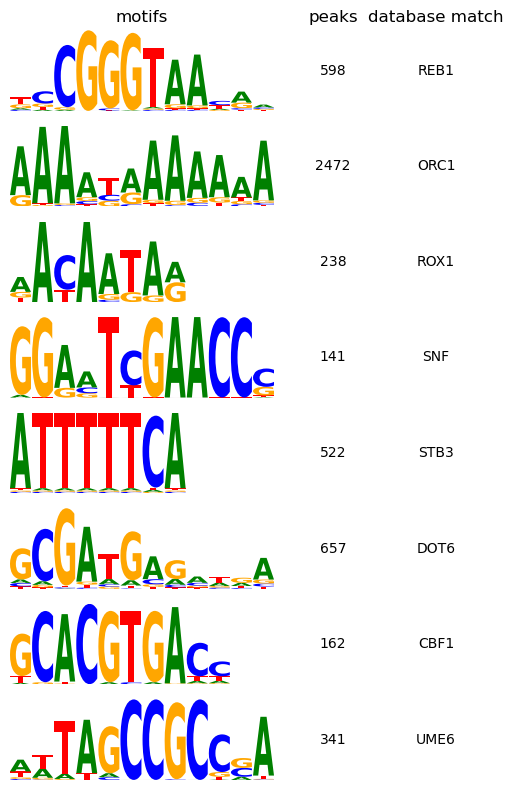

In [245]:
fig, axes = plt.subplots(8, 3, figsize=(5, 8), facecolor='w', layout='tight', sharex='col', width_ratios=[3, 1, 1])
for i, motif_id in enumerate(sorted(df_streme_in_yeast.motif_id.unique())):
    # if i >= len(axes):
    #     break
    motif = get_motif(motif_id, f"/home/alex/xstreme_nomeme_background_W303_saliency_{model_name}_peaks_yeastchroms{suffix}/streme_out/streme.txt")
    plot_motif(motif, ax=axes[i, 0])
    # axes[i, 0].set_title(motif_id)

    n_peaks_with_motif = sites_with_motif[motif_id]
    # prop = 100 * n_peaks_with_motif / len(sites)

    axes[i, 1].text(.5, .5,
        f"{n_peaks_with_motif}",
        ha='center', va='center'
        # xy=(.4, .5),
        # xycoords='axes fraction'
    )
    if motif_match[i] is not None:
        alt_motif_id, alt_database = motif_match[i]
        axes[i, 2].text(.5, .5,
            f"{alt_motif_id[:4].upper()}",
            ha='center', va='center'
            # xy=(.4, .5),
            # xycoords='axes fraction'
        )
axes[0, 0].set_title("motifs")
axes[0, 1].set_title("peaks")
axes[0, 2].set_title("database match")
for ax in axes.flatten():
    ax.set_axis_off()
save_fig_and_values(fig, f"/home/alex/motifs_xstreme_{model_name}_saliency_peaks_min2_merge19_extend10", format='svg')

In [59]:
with pd.option_context('display.max_rows', None):
    display(df.groupby("sequence_name").count())

,index,motif_id,motif_alt_id,start,stop,strand,score,p-value,q-value,matched_sequence
sequence_name,,,,,,,,,,
chrI,35,35,35,35,35,35,35,35,35,35
chrII,195,195,195,195,195,195,195,195,195,195
chrIII,70,70,70,70,70,70,70,70,70,70
chrIV,354,354,354,354,354,354,354,354,354,354
chrIX,89,89,89,89,89,89,89,89,89,89
chrV,119,119,119,119,119,119,119,119,119,119
chrVI,57,57,57,57,57,57,57,57,57,57
chrVII,263,263,263,263,263,263,263,263,263,263
chrVIII,111,111,111,111,111,111,111,111,111,111


In [348]:
chrom = "chrXVI"
with np.load(f"/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/saliency_model_myco_nuc_2_{chrom}_onseq.npz") as f:
    grads = f['arr_0']

In [349]:
WINDOW = grads.shape[1]
sumabs_grads = np.zeros(len(grads) + WINDOW - 1)
for j in range(WINDOW):
    sumabs_grads[j : len(sumabs_grads) - WINDOW + j + 1] += np.abs(
        grads[:, j]
    )
sumabs_grads /= WINDOW
sumabs_grads = z_score(sumabs_grads)

In [350]:
with np.load("/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/preds_on_W303_Mmmyco.npz") as f:
    preds = (f[chrom] + f[chrom]) / 2
with np.load("/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.npz") as f:
    one_hots = f[chrom]

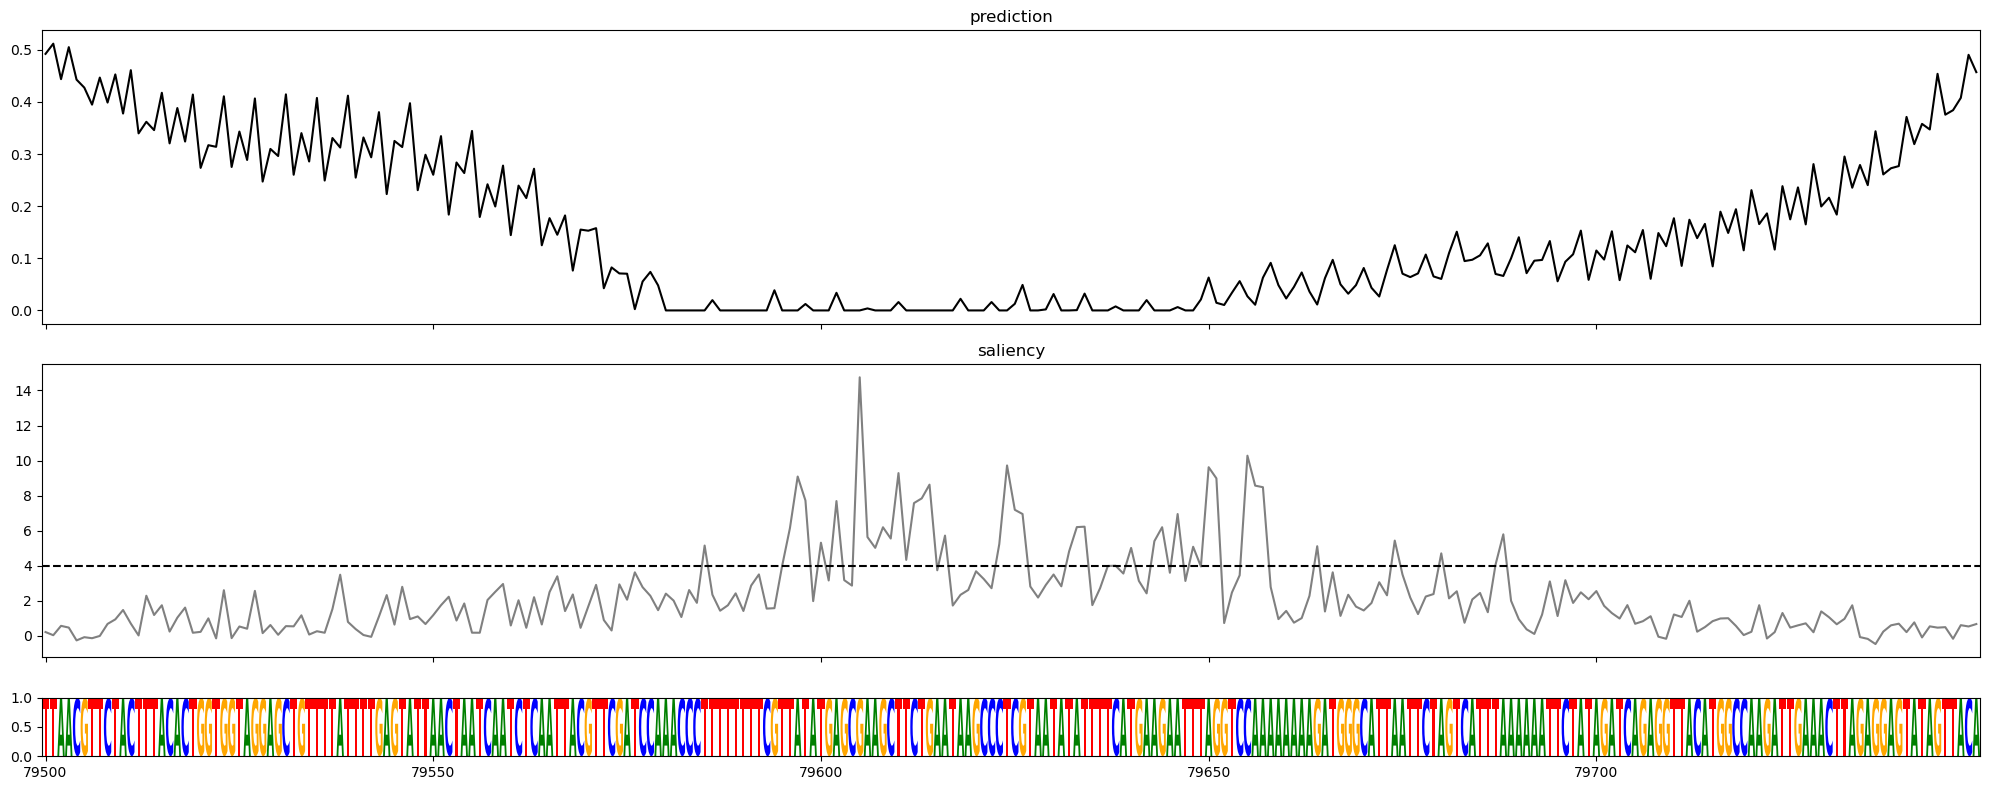

In [383]:
start = 79500
stop = start + 250
fig, axes = plt.subplots(3, 1, figsize=(20, 8), facecolor="w", layout='tight', sharex=True, gridspec_kw={"height_ratios": [5, 5, 1]})
axes[0].set_title("prediction")
axes[0].plot(np.arange(start, stop), preds[start:stop], color='k')
axes[1].set_title("saliency")
axes[1].plot(np.arange(start, stop), sumabs_grads[start:stop], color='gray')
axes[1].axhline(y=4, color='k', linestyle='--', label="peak threshold")
if stop - start < 1000:
    lm.Logo(
        pd.DataFrame(
            one_hots[start:stop],
            columns=list("ACGT"),
            index=np.arange(start, stop),
        ),
        ax=axes[2],
    )
# sites = df_streme.loc[(df.start < stop) & (df.stop > start), ["motif_id", "start", "stop"]]
# print(len(sites))
# for ax in axes:
#     seen_mids = {}
#     for mid, mstart, mstop in sites.values:
#         label = None
#         if mid not in seen_mids:
#             seen_mids[mid] = len(seen_mids)
#             label = mid
#         color = colors[seen_mids[mid]]
#         ax.axvline(mstart, color=color, linestyle='--', label=label)
#         ax.plot([mstart, mstop], [.9, .9], color=color, marker=".")
# axes[1].legend()

In [406]:
[seq.id for seq in SeqIO.parse("/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa", format='fasta')]

['chrI',
 'chrII',
 'chrIII',
 'chrIV',
 'chrV',
 'chrVI',
 'chrVII',
 'chrVIII',
 'chrIX',
 'chrX',
 'chrXI',
 'chrXII',
 'chrXIII',
 'chrXIV',
 'chrXV',
 'chrXVI',
 'Mmmyco']

In [1]:
model_name = "model_myco_nuc_17"
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_name}/saliency_{model_name}_W303_Mmmyco_onseq_sumabs.npz"
) as f:
    sumabs_grads_dict = {k: f[k] for k in f.keys()}

NameError: name 'np' is not defined

In [ ]:
def z_score_dict(dico):
    all_values = np.concatenate(list(dico.values()))
    mean, std = np.mean(all_values), np.std(all_values)
    return {k: (v - mean) / std for k, v in dico.items()}


def make_peaks(
    peak_mask: np.ndarray, length_thres: int = 1, tol: int = 1
) -> np.ndarray:
    """Format peak array from peak boolean mask.

    Determine regions of consecutive high prediction, called peaks.

    Parameters
    ----------
    peak_mask : ndarray
        1D-array of boolean values along the chromosome
    length_thres : int, default=1
        Minimum length required for peaks, any peak strictly below that
        length will be discarded
    tol : int, default=1
        Distance between consecutive peaks under which the peaks are merged
        into one. Can be set higher to get a single peak when signal is
        fluctuating too much. Unlike slices, peaks include their end points,
        meaning [1 2] and [4 5] actually contain a gap of one base,
        but the distance is 2 (4-2). The default value of 1 means that no
        peaks will be merged.

    Returns
    -------
    peaks : ndarray, shape=(n, 2)
        2D-array, each line corresponds to a peak. A peak is a 1D-array of
        size 2, with format [peak_start, peak_end]. `peak_start` and
        `peak_end` are indices on the chromosome.
    """
    # Find where peak start and end
    change_idx = np.where(peak_mask[1:] != peak_mask[:-1])[0] + 1
    if peak_mask[0]:
        # If predictions start with a peak, add an index at the start
        change_idx = np.insert(change_idx, 0, 0)
    if peak_mask[-1]:
        # If predictions end with a peak, add an index at the end
        change_idx = np.append(change_idx, len(peak_mask))
    # # Check that change_idx contains as many starts as ends
    # assert (len(change_idx) % 2 == 0)
    # Merge consecutive peaks if their distance is below a threshold
    if tol > 1:
        # Compute difference between end of peak and start of next one
        diffs = change_idx[2::2] - change_idx[1:-1:2]
        # Get index when difference is below threshold, see below for matching
        # index in diffs and in change_idx
        # diff index:   0   1   2  ...     n-1
        # change index:1-2 3-4 5-6 ... (2n-1)-2n
        (small_diff_idx,) = np.where(diffs <= tol)
        delete_idx = np.concatenate((small_diff_idx * 2 + 1, small_diff_idx * 2 + 2))
        # Remove close ends and starts using boolean mask
        mask = np.ones(len(change_idx), dtype=bool)
        mask[delete_idx] = False
        change_idx = change_idx[mask]
    # Reshape as starts and ends
    peaks = np.reshape(change_idx, (-1, 2))
    # Compute lengths of peaks and remove the ones below given threshold
    lengths = np.diff(peaks, axis=1).ravel()
    peaks = peaks[lengths >= length_thres]
    return peaks


def find_peaks(
    preds: np.ndarray, pred_thres: float, length_thres: int = 1, tol: int = 1
) -> np.ndarray:
    """Determine peaks from prediction signal and threshold.

    Identify when `preds` is above the threshold `pred_thres` pointwise,
    then determine regions of consecutive high prediction, called peaks.

    Parameters
    ----------
    preds : ndarray
        1D-array of predictions along the chromosome
    pred_thres : float
        Threshold above which prediction is considered in a peak
    length_thres : int, default=1
        Minimum length required for peaks, any peak below or equal to that
        length will be discarded
    tol : int, default=1
        Distance between consecutive peaks under which the peaks are merged
        into one. Can be set higher to get a single peak when signal is
        fluctuating too much. Unlike slices, peaks include their end points,
        meaning [1 2] and [4 5] actually contain a gap of one base,
        but the distance is 2 (4-2). The default value of 1 means that no
        peaks will be merged.

    Returns
    -------
    peaks : ndarray, shape=(n, 2)
        2D-array, each line corresponds to a peak. A peak is a 1D-array of
        size 2, with format [peak_start, peak_end]. `peak_start` and
        `peak_end` are indices on the chromosome.
    """
    # Find pointwise peaks as predictions above the threshold
    peak_mask = preds > pred_thres
    return make_peaks(peak_mask, length_thres, tol)